In [16]:
# Tensorflow
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, Dropout, MaxPool2D, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
# TF extensions
from tensorboard.plugins.hparams import api as hp
# Python
import os
import json
from functools import partial
from google.cloud import storage
# Custom
from utils import preview

In [18]:
# Cloud storage
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '../credentials/sticky-notes1-data-access.json'
USE_CLOUD_STORAGE = True
BUCKET_NAME = 'sticky-notes1'

# Add before any TF calls - initializes the keras global outside of any tf.functions
temp = tf.zeros([4, 32, 32, 3])
preprocess_input(temp);
AUTOTUNE = tf.data.experimental.AUTOTUNE
# strategy = tf.distribute.MirroredStrategy()
# print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

In [27]:
data_dir

'gs://sticky-notes1/training-data'

In [34]:
def load_metadata(tfrecord_path):
    data_dir = os.path.dirname(tfrecord_path)
    if USE_CLOUD_STORAGE:
        client = storage.Client()
        bucket = client.get_bucket(BUCKET_NAME)
        data_dir = data_dir.replace(f'gs://{BUCKET_NAME}/', '')
        print(data_dir)
        print(os.path.join(data_dir, 'METADATA.json'))
        blob = bucket.get_blob(os.path.join(data_dir, 'METADATA.json'))
        metadata = blob.download_as_string()
        metadata = json.loads(metadata)
    else:
        metadata = json.load(open(os.path.join(data_dir, 'METADATA.json')))
    return metadata

def parse_image(tfrecord, tfrecord_feature_description, image_shape):
    """
    Parse image, label and bounding box from a tfrecord example
    """
    # Parse single example
    tf_example = tf.io.parse_single_example(tfrecord, tfrecord_feature_description)
    # Decode and preprocess image
    image = tf.io.decode_raw(tf_example['image_raw'], tf.uint8)
    image = tf.reshape(image, image_shape)
    image = preprocess_input(image)
    # Decode label
    label = tf_example['label']
    label = (label == 'stickie')
    #bbox = tf_example['bbox']
    return image, label

def read_dataset(tfrecord_path, batch_size=32):
    """
    Read tfrecord dataset of images, labels and bounding boxes from storage
    """
    # Arguments for data parsing
    metadata = load_metadata(tfrecord_path)
    image_shape = (
        metadata['dimensions']['height'],
        metadata['dimensions']['width'],
        metadata['dimensions']['channels']
    )
    tfrecord_feature_description = {
        'image_raw': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.string),
        'bbox': tf.io.FixedLenFeature([], tf.string)
    }
    
    # Load and parse data
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    dataset = dataset.map(
        lambda x: parse_image(x, tfrecord_feature_description, image_shape),
        num_parallel_calls=AUTOTUNE
    )
    # Repeat, shuffle, batch and prefetch
    dataset = dataset.repeat(None).shuffle(1000).batch(batch_size).prefetch(AUTOTUNE)
    
    # Determine how many steps to run per epoch from the metadata
    split = tfrecord_path.split('/')[-1].split('.')[0]  # returns train/val/test
    num_examples = metadata['num_examples'][split]
    num_steps = num_examples // batch_size

    return dataset, num_steps

In [5]:
# Custom Hparams callbacks
class HparamsMetricCallback(tf.keras.callbacks.Callback):
    """
    Metric callback for Hparams dashboard
    Eager execution mode only (there might be a way to use @tf.function)
    """
    def __init__(self, metric, log_dir):
        """
        Arguments:
        - metric - str - validation metric (should correspond to a metric used in `model.compile`)
        - log_dir - str - log directory to store the metric (should be same dir as Tensorboard)
        
        Example:
        ```
        model.compile(..., metrics=['accuracy'])
        tensorboard_cb = Tensorboard(log_dir=log_dir)
        hparams_metric_cb = HparamsMetricCallback(metric='val_accuracy', log_dir=log_dir)
        ```
        """
        self.metric = metric
        self.log_dir = log_dir

    def on_epoch_end(self, epoch, logs):
        """
        This function will automatically be called during a model.fit() call
        Creates a tf.summary from the validation metric stored in the training logs
        """
        with tf.summary.create_file_writer(self.log_dir).as_default():
            tf.summary.scalar(self.metric, logs[self.metric], epoch)

            
def create_hparams_callbacks(log_dir, opt_metric, hparams):
    """
    Create the two callbacks necessary to use hparams in Tensorboard
    """
    # Hparams metric callback to log the validation score
    hparams_metric_cb = HparamsMetricCallback(
        metric=opt_metric,
        log_dir=log_dir
    )
    # Hparams callback to log the hyperparameter values
    with tf.summary.create_file_writer(log_dir).as_default():
        hp.hparams_config(
            hparams=[hp.HParam(hparam)for hparam in hparams],
            metrics=[hp.Metric(opt_metric)]
        )
    hparams_cb = hp.KerasCallback(
        writer=log_dir,
        hparams={hparam: args[hparam] for hparam in hparams}
    )
    return hparams_metric_cb, hparams_cb

In [6]:
def create_model(args, metrics):
    """
    Create trainable model initialised from VGG-16 pretrained on ImageNet
    """
    # Pre-trained model
    vgg = VGG16(weights='imagenet', input_tensor=Input(shape=(224,224,3)), include_top=False)
    vgg.trainable = False
    for layer in vgg.layers:
        layer.trainable = False
    
    # Add trainable output layer
    flatten_layer = Flatten()
    output_layer = Dense(1, activation='sigmoid', kernel_regularizer=l2(l=args['l2_regularisation']))
    output = vgg.layers[-1].output
    output = output_layer(flatten_layer(output))
    model = Model(vgg.input, output)
    
    # Compile
    model.compile(
        loss="binary_crossentropy",
        optimizer=Adam(learning_rate=args['learning_rate']),
        metrics=metrics
    )

    return model

In [7]:
# View the network architecture and number of parameters
#create_model({'learning_rate': 0.1, 'l2_regularisation': 0.1}, ['accuracy']).summary()

In [8]:
def train_and_evaluate(args):
    """
    Main training function
    Training logs and model checkpoints will be stored in args['job_dir']

    Arguments:
    - args - dict - Training parameters.
      Should contain:
        - 'learning_rate'     - float - initial learning rate for training
        - 'l2_regularisation' - float - regularisation used for dense (fully connected) layers
        - 'batch_size'        - int   - mini-batch size used using training (Adam optimisation)
        - 'epochs'            - int   - number of training epochs
        - 'job_dir'           - str   - job directory used to store the logs and model checkpoints
    """
    # Training parameters
    metrics = ['accuracy']
    opt_metric = 'val_accuracy'
    hparams = ['learning_rate', 'l2_regularisation']
    log_dir = os.path.join(args['job_dir'], 'training-logs')
    model_dir = os.path.join(args['job_dir'], 'model-weights.tf')

    # Model definition
    model = create_model(args, metrics)

    # Callback definition
    tensorboard_cb = TensorBoard(
        log_dir=log_dir
    )
    checkpoint_cb = ModelCheckpoint(
        filepath=model_dir,
        save_format='tf',
        monitor=opt_metric,
        mode='max',
        save_freq='epoch',
        save_weights_only=True,
        save_best_only=True,
        verbose=0
    )
    hparams_metric_cb, hparams_cb = create_hparams_callbacks(log_dir, opt_metric, hparams)
    callbacks = [tensorboard_cb, checkpoint_cb, hparams_metric_cb, hparams_cb]

    # Load data
    train_tfrecord_path, val_tfrecord_path = [
        os.path.join(args['data_dir'], split + '.tfrecord') for split in ['train', 'val']
    ]
    train_dataset, train_steps = read_dataset(train_tfrecord_path, args['batch_size'])
    val_dataset, val_steps = read_dataset(val_tfrecord_path, args['batch_size'])

    # Train model
    model.fit(
        train_dataset,
        epochs=int(args['epochs'] * args['epoch_split']),
        steps_per_epoch=train_steps // args['epoch_split'],
        validation_data=val_dataset,
        validation_steps=3,
        callbacks=callbacks,
        verbose=1
    )
    return model

In [9]:
! rm -r ../train-output  # remove logs from previous training session

<h3>  &nbsp;&nbsp;Train on TPU&nbsp;&nbsp; <a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a></h3>

1. On the main menu, click Runtime and select **Change runtime type**. Set "TPU" as the hardware accelerator.
1. Click Runtime again and select **Runtime > Run All**. You can also run the cells manually with Shift-ENTER. 

In [36]:
if USE_CLOUD_STORAGE:
    data_dir = f'gs://{BUCKET_NAME}/training-data'
    job_dir = f'gs://{BUCKET_NAME}/training-jobs'
else:
    data_dir = '../data/processed/tfrecords/200429_141738'
    job_dir = '../train-output'

for learning_rate in [0.01]:#, 0.001]:
    args = {
        'learning_rate': learning_rate,
        'l2_regularisation': 0.01,
        'batch_size': 16,
        'epochs': 2,
        'epoch_split': 1,  # split epoch to see training progress more frequently
        'job_dir': job_dir,
        'data_dir': data_dir,
    }

#     resolver = tf.contrib.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
#     tf.contrib.distribute.initialize_tpu_system(resolver)
#     strategy = tf.contrib.distribute.TPUStrategy(resolver)

#     with strategy.scope():
    train_and_evaluate(args)

training-data
training-data/METADATA.json
training-data
training-data/METADATA.json
Train for 500 steps, validate for 3 steps
Epoch 1/2
 10/500 [..............................] - ETA: 48:34 - loss: 1.0531 - accuracy: 0.9375WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


KeyError: 'val_accuracy'

In [11]:
# ! poetry run tensorboard --logdir='train-output/training-logs'
# ! tensorboard --logdir='../train-output/training-logs'

# Test

### Similar to training set

In [35]:
from PIL import Image
import numpy as np

test_set, _ = read_dataset('../data/processed/tfrecords/200429_141738/train.tfrecord')

for item in test_set.take(5):
    img = item[0]
    np_img = img.numpy()
    print(np_img[0].min())
    print(np_img[0].max())
    display(Image.fromarray(np_img[0]))
    np_img = np.array(img)
    np_img = np_img.reshape(1, *np_img.shape)
    if model.predict(np_img)[0][0] == 1:
        print('stickie')
    else:
        print('not stickie')

../data/processed/tfrecords/200429_141738
../data/processed/tfrecords/200429_141738/METADATA.json


AttributeError: 'NoneType' object has no attribute 'download_as_string'

### Random online image

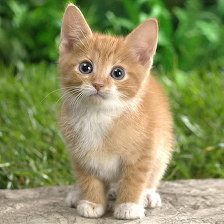

stickie


In [160]:
import requests
from io import BytesIO
from PIL import Image
import numpy as np
import cv2

url = 'https://pytorch.org/tutorials/_images/cat_superres_with_ort.jpg'
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img

np_img = np.array(img)
np_img = cv2.resize(np_img, (224, 224))
np_img = np_img.reshape(1, *np_img.shape)
display(Image.fromarray(np_img[0]))

if model.predict(np_img)[0][0] == 1:
    print('stickie')
else:
    print('not stickie')

### Real world images

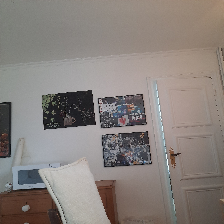

stickie


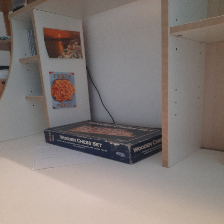

stickie


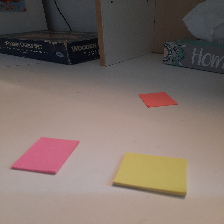

stickie


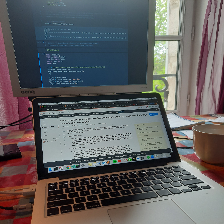

stickie


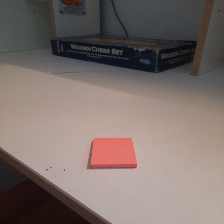

stickie


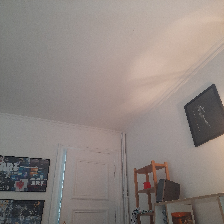

not stickie


In [198]:
test_dir = '../data/raw/test_images'
for image in os.listdir(test_dir):
    img = Image.open(os.path.join(test_dir, image))
    np_img = np.array(img)
    np_img = cv2.rotate(np_img, 0)
    np_img = np_img[:3500]
    np_img = cv2.resize(np_img, (224, 224))
    display(Image.fromarray(np_img))
    np_img = np_img.reshape(1, *np_img.shape)
    tf_img = preprocess_input(np_img)
    
    if model.predict(tf_img)[0][0] == 1:
        print('stickie')
    else:
        print('not stickie')